## Tabular data: post-hoc explanations
### Author: Francesca Naretto

In [10]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from xai.xailib.data_loaders.dataframe_loader import prepare_dataframe

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer

from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

ModuleNotFoundError: No module named 'externals.LOREM'

### Load the german dataset and prepare it
#### The german credit dataset is a small dataset which classifies people as high or low credit risk. It contains several features, most of them categorical. 

In [1]:
source_file = 'datasets/german_credit.csv'
class_field = 'default'
# Load and transform dataset 
df = pd.read_csv(source_file, skipinitialspace=True, na_values='?', keep_default_na=True)

NameError: name 'pd' is not defined

In [8]:
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(df, class_field)

### Split the dataset into train and test and scale it

In [9]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[class_field],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[class_field])



### Define and train a logistic regression model

In [10]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

bb = LogisticRegression(C=1, penalty='l2')
bb.fit(X_scaled, Y_train.values)
# pass the model to the wrapper to use it in the XAI lib
bbox = sklearn_classifier_wrapper(bb)

In [11]:
# select a record to explain
inst = X_scaled[182]
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[18])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [ 2.27797454  3.35504085  0.94540357  1.07634233  0.04854891 -0.72456474
 -0.43411405  1.65027399 -0.61477862 -0.25898489]
True class  1
Predicted class  [1]


### SHAP explainer
##### We first define the explainer method we want to use: SHAP. It produces feature importance. Then, we can define a dictionary containing the SHAP's parameters we want. 
##### Explainer can be: linear, tree, kernel, deep
##### X_train is the training set we want the explainer to train on. It can be all the training set used for the training of the target model, just a piece of it or we can apply a clustering algorithm on it. 

In [12]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'linear', 'X_train' : X_scaled[0:100], 'feature_pert' : 'interventional'}

explainer.fit(config)

#### We explain the instance and obtain the SHAP values

In [13]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp)

building an explanation


In [14]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer
##### We first define the explainer method we want to use: LORE. It produces rules and counterfactual rules. We can define a dictionary containing the LORE's parameters we want. 
##### neigh_type can be: random, genetic, rndgen, geneticp, rndgenp

In [16]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

r = { age <= 20.73, credit_amount > -439.64, purpose=retraining <= 0.12, duration_in_month > -1.94, purpose=furniture/equipment <= 0.18, foreign_worker=no <= 0.72, purpose=domestic appliances <= 1.02, savings=.. >= 1000 DM  <= 0.72, purpose=(vacation - does not exist?) <= 0.46, credit_history=critical account/ other credits existing (not at this bank) <= 0.91, people_under_maintenance <= -0.01 } --> { default: 1 }
c = { { credit_amount <= -439.64 },
      { age > 20.73 } }


### LIME explainer
##### We first define the explainer method we want to use: LIME. It produces feature importances. We can define a dictionary containing the LIME's parameters we want. 
##### There are several parameters we can define: feature selection, discretize continuous, discretizer, sample_around_instance, kernel width, kernel.

In [17]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

[('other_debtors=co-applicant', -1.2099484483255092e-09), ('credit_history=all credits at this bank paid back duly', -9.807292855860074e-10), ('present_emp_since=unemployed', -8.905493791597428e-10), ('other_debtors=none', 6.501490037885416e-10), ('housing=for free', -4.510074423165453e-10), ('credit_amount', 3.434739931156657e-10), ('job=management/ self-employed/ highly qualified employee/ officer', -3.072084086389175e-10), ('property=unknown / no property', -3.0472604540923717e-10), ('savings=unknown/ no savings account', -3.0122747825365184e-10), ('savings=... < 100 DM', 2.405511062391587e-10), ('credits_this_bank', 2.371877264255121e-10), ('housing=own', 2.198182579019193e-10), ('property=real estate', 1.942527163166695e-10), ('account_check_status=0 <= ... < 200 DM', -1.8341777236604474e-10), ('foreign_worker=yes', 1.7351459527660338e-10), ('purpose=car (new)', -1.6299442716105222e-10), ('account_check_status=no checking account', 1.6227117790107726e-10), ('people_under_maintenan

##### To plot the explanation, we pass the explanation as a list (tuples, where the first element is the feature name and the second the actual feature importance), start and end of the range of features we want to visualize.

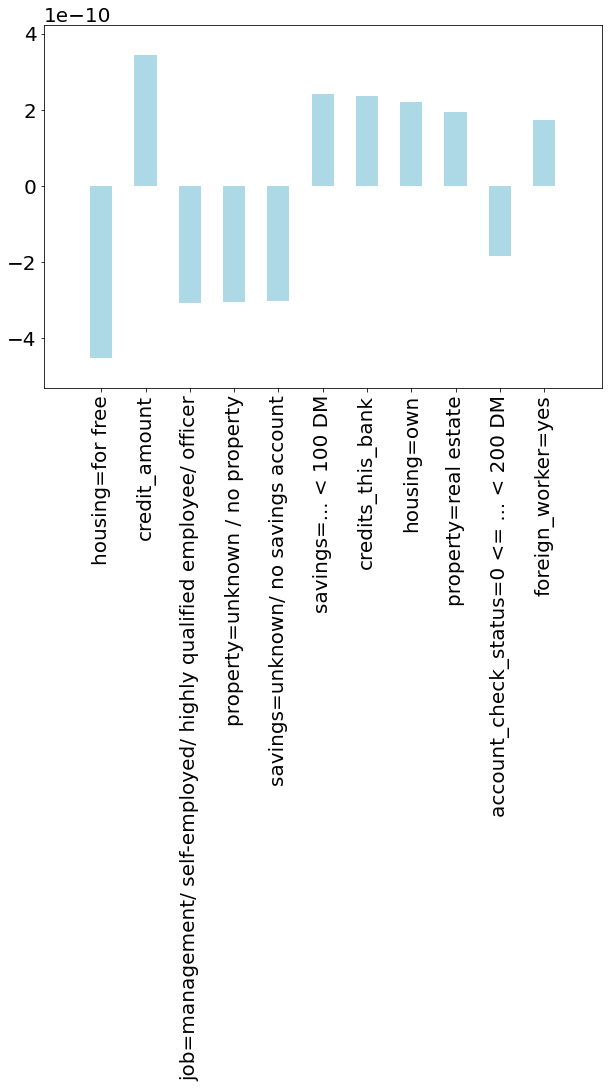

In [18]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 4, 15)

### Define and train a RFClassifier

In [14]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)
bbox = sklearn_classifier_wrapper(bb)   

In [15]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'tree', 'X_train' : X_train.iloc[0:100].values}
explainer.fit(config)

In [16]:
inst = X_train.iloc[147].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[8])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [ 15 975   2   3  25   2   1   0   1   0]
True class  0
Predicted class  [0]


In [17]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp.exp)

building an explanation
[array([ 4.88664708e-02,  3.87472686e-03,  2.59326271e-02,  9.82242474e-04,
        1.97730355e-02, -4.55620361e-03,  6.69295353e-04,  2.30659473e-02,
       -2.99598466e-02,  2.15886219e-03, -3.21642844e-02,  4.08956682e-03,
        6.25140388e-02,  9.67738209e-04,  7.90526160e-03,  1.72965796e-03,
        5.90766030e-03,  1.48980517e-04,  1.62838034e-02, -9.84048172e-04,
       -7.15918713e-04, -1.81295428e-04, -1.89275553e-04, -6.98170930e-03,
        1.43126352e-03, -4.49307919e-05, -6.25580201e-04, -2.68106303e-03,
        3.29592905e-03, -2.72225214e-04, -4.81564678e-03,  1.30068318e-02,
        2.19933278e-02,  9.50438313e-03,  2.13763356e-03,  3.48123135e-03,
        1.98078847e-03,  3.67890663e-03,  9.45348723e-04,  3.85162006e-03,
        1.67917662e-03, -1.87606883e-03, -1.08906011e-03,  2.76546370e-02,
        1.42611145e-03, -1.51476933e-02,  1.11595232e-02,  9.69341599e-03,
        1.74427581e-02,  5.77029870e-04, -1.82240160e-04,  1.78363943e-02,


In [18]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer

In [ ]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

### LIME explainer

In [ ]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

In [ ]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 5, 10)